<a href="https://colab.research.google.com/github/SifaMansuri/Final-Tweeteval/blob/main/final_project_hate_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings 
warnings.filterwarnings('ignore')
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)
import plotly.graph_objs as go
import cufflinks
pd.options.display.max_columns = 30
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()
from collections import Counter
from pprint import pprint
import en_core_web_sm

In [ ]:
TRAIN_TEXT = 'https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/hate/train_text.txt'
VAL_TEXT = 'https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/hate/val_text.txt'
TEST_TEXT = 'https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/hate/test_text.txt'

TRAIN_LABEL = 'https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/hate/train_labels.txt'
VAL_LABEL = 'https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/hate/val_labels.txt'
TEST_LABEL = 'https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/hate/test_labels.txt'


In [ ]:
def convert_to_df(data, label):
    tweet = []
    sentiments = []
    for sentence in data.split('\n'):
        tweet.append(sentence)
    for sentiment in label.split('\n'):
        try:
            sentiments.append(int(sentiment))
        except ValueError:
            pass
    df= pd.DataFrame(tweet[:-1], columns=['Review Text'])
    df['label'] = sentiments # this colums contains labels in int format

    df['sentiment'] = df.label.apply(lambda x: 'Not-hate'if x==0 else 'hate')

    return df

In [ ]:
import requests
train_tweets_txt = requests.get(TRAIN_TEXT).text
train_labels_txt = requests.get(TRAIN_LABEL).text

val_tweets_txt = requests.get(VAL_TEXT).text
val_labels_txt = requests.get(VAL_LABEL).text

test_tweets_txt = requests.get(TEST_TEXT).text
test_labels_txt = requests.get(TEST_LABEL).text

train_df = convert_to_df(train_tweets_txt, train_labels_txt)
val_df = convert_to_df(val_tweets_txt, val_labels_txt)
test_df = convert_to_df(test_tweets_txt, test_labels_txt)



In [ ]:
df = train_df

([<matplotlib.patches.Wedge at 0x7f44366233d0>,
 [Text(-0.27244302339559684, 1.0657273567864656, 'Not-hate'),
  Text(0.27244302339559673, -1.0657273567864656, 'hate')],
 [Text(-0.14860528548850735, 0.5813058309744357, '58.0%'),
  Text(0.1486052854885073, -0.5813058309744358, '42.0%')])

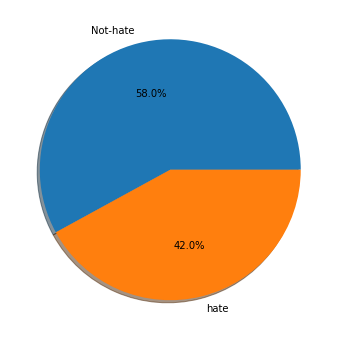

In [ ]:
eda = df.groupby('sentiment').count()['Review Text'].reset_index().sort_values(by='Review Text',ascending=False)
labels = list(eda.sentiment)
sizes = list(eda['Review Text'])

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True)
plt.show()

In [ ]:
def preprocess(ReviewText):
    ReviewText = ReviewText.str.replace("(<br/>)", "")
    ReviewText = ReviewText.str.replace('(<a).*(>).*(</a>)', '')
    ReviewText = ReviewText.str.replace('(&amp)', '')
    ReviewText = ReviewText.str.replace('(&gt)', '')
    ReviewText = ReviewText.str.replace('(&lt)', '')
    ReviewText = ReviewText.str.replace('(\xa0)', ' ')  
    return ReviewText
df['Review Text'] = preprocess(df['Review Text'])

New column for sentiment polarity. Two new columns for lengths of the review and word count.

In [ ]:
df['polarity'] = df['Review Text'].map(lambda text: TextBlob(text).sentiment.polarity)
df['review_len'] = df['Review Text'].astype(str).apply(len)
df['word_count'] = df['Review Text'].apply(lambda x: len(str(x).split()))

In [ ]:
print('5 random reviews with the highest positive sentiment polarity: \n')
cl = df.loc[df.polarity == 1, ['Review Text']].sample(5).values
for c in cl:
    print(c[0])

5 random reviews with the highest positive sentiment polarity: 

Called 844-4STAND5 to let my legislators know I #standwithrefugees. The calling system worked flawlessly except for the part where I cried. 
#NikkiHaley welcomes #Muslimrefugees @user " It's a great day in #Sunni #SouthCarolina " @user @user 4600 + #SunniMuslims ALONE in our capital city JUST 1 CITY! #sctweets #stopimmigration 
'Replaceable' best describes your life 🤗 
@user You are very brave to tell your story. I promise you not all men are monsters. ❤️ 
The best way to stay off the grid is by posting about it 


In [ ]:
print('5 random reviews with the most neutral sentiment(zero) polarity: \n')
cl = df.loc[df.polarity == 0, ['Review Text']].sample(5).values
for c in cl:
    print(c[0])

5 random reviews with the most neutral sentiment(zero) polarity: 

The EU’s migration solution? Throw cash at the problem 
And now another flood of immigrants coming our way.#BuildThatWall 
@user a forrest of refugees the leaves fall of called children but lets not be conned people play on it we have children to 
@user @user You lieing kunt! 
Retweeted DRUDGE REPORT (@DRUDGE_REPORT): British actress becomes fifth woman to accuse of rape...... 


### Dist plot of review polarity score

In [ ]:
df['polarity'].iplot(
    kind='hist',
    bins=50,
    xTitle='polarity',
    linecolor='black',
    yTitle='count',
    title='Sentiment Polarity Distribution')

Vast majority of the polarity are greater than 0, means most of them are positive.

### Distribution of ratings

The ratings are in align with the polarity, that is, most of the ratings are at 4 or 5 range.

### Reviewers age distribution

Most reviewers are in their 30s to 40s.

In [ ]:
df['review_len'].iplot(
    kind='hist',
    bins=100,
    xTitle='review length',
    linecolor='black',
    yTitle='count',
    title='Review Text Length Distribution')

### Top unigrams before removing stop words

In [ ]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(df['Review Text'], 20)
for word, freq in common_words:
    print(word, freq)
df1 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])

user 6015
the 5508
to 4794
you 3726
and 3229
of 2881
in 2574
is 2052
for 1830
are 1614
that 1514
not 1378
it 1373
on 1183
bitch 1075
they 1070
this 1049
all 1043
your 971
be 944


### Top unigrams after removing stop words

In [ ]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(df['Review Text'], 20)
for word, freq in common_words:
    print(word, freq)
df2 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])

user 6015
bitch 1075
refugees 893
women 859
immigrant 732
like 680
immigration 671
illegal 592
migrants 532
just 532
men 526
people 505
don 503
woman 467
cunt 458
rape 458
trump 429
whore 405
immigrants 381
buildthatwall 372


### Top bigrams before removing stop words

In [ ]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(df['Review Text'], 20)
for word, freq in common_words:
    print(word, freq)
df3 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])

user user 2237
in the 473
of the 379
you re 300
not all 270
via user 270
all men 254
to be 254
if you 227
to the 223
you are 207
on the 200
when you 195
user you 184
for the 183
this is 177
they are 147
want to 143
is the 139
you can 135


In [ ]:
df3.groupby('ReviewText').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 bigrams in review before removing stop words')

### Top bigrams after removing stop words

In [ ]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(df['Review Text'], 20)
for word, freq in common_words:
    print(word, freq)
df4 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])

user user 2270
illegal immigrants 106
free speech 99
speech time 92
time user 92
trump maga 91
illegal immigration 84
rt user 79
illegal aliens 77
shut fuck 74
year old 73
illegal alien 69
immigrant children 68
illegal migrants 67
illegal immigrant 67
user bitch 66
hysterical woman 65
ass bitch 50
user women 49
syrian refugees 48


In [ ]:
df4.groupby('ReviewText').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 bigrams in review after removing stop words')

### Top trigrams before removing stop words

In [ ]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(df['Review Text'], 20)
for word, freq in common_words:
    print(word, freq)
df5 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])

user user user 1185
not all men 241
free speech time 92
speech time user 92
the fuck up 74
all men are 72
shut the fuck 71
user user you 61
when you re 57
trump maga rednationrising 40
year old girl 35
to go home 35
you have to 34
user you are 32
withrefugees user user 29
we need to 28
buildthatwall buildthatwall buildthatwall 27
first of all 25
most hysterical woman 24
user user this 24


In [ ]:
df5.groupby('ReviewText').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 trigrams in review before removing stop words')

### Top trigrams after removing stop words

In [ ]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(df['Review Text'], 20)
for word, freq in common_words:
    print(word, freq)
df6 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])

user user user 1193
free speech time 92
speech time user 92
trump maga rednationrising 40
year old girl 35
withrefugees user user 30
buildthatwall buildthatwall buildthatwall 27
user user bitch 24
user user buildthewall 24
ha ha ha 18
ðÿ ðÿ ðÿ 18
user buildthewall lockthemup 16
13 year old 15
buildthewall lockthemup enddaca 15
user user women 15
user shut fuck 14
woman accused nelly 14
accused nelly rape 14
user user don 13
german government pays 13


In [ ]:
df6.groupby('ReviewText').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 trigrams in review after removing stop words')

### Top 20 part-of-speech tagging of review corpus

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
blob = TextBlob(str(df['Review Text']))
pos_df = pd.DataFrame(blob.tags, columns = ['word' , 'pos'])
pos_df = pos_df.pos.value_counts()[:20]
pos_df.iplot(
    kind='bar',
    xTitle='POS',
    yTitle='count', 
    title='Top 20 Part-of-speech tagging for review corpus')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

### Topic Modeling with LSA

In [ ]:
reindexed_data = df['Review Text']
tfidf_vectorizer = TfidfVectorizer(stop_words='english', use_idf=True, smooth_idf=True)
reindexed_data = reindexed_data.values
document_term_matrix = tfidf_vectorizer.fit_transform(reindexed_data)

In [ ]:
n_topics = 6
lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(document_term_matrix)

In [ ]:
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [ ]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

In [ ]:
def get_top_n_words(n, keys, document_term_matrix, tfidf_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = tfidf_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [ ]:
top_n_words_lsa = get_top_n_words(3, lsa_keys, document_term_matrix, tfidf_vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])

Topic 1:  user bitch women
Topic 2:  bitch hoe ass
Topic 3:  refugees men women
Topic 4:  men neverrrrrrrrrrr information_warfare
Topic 5:  cunt woman stupid
Topic 6:  illegal immigrant buildthatwall


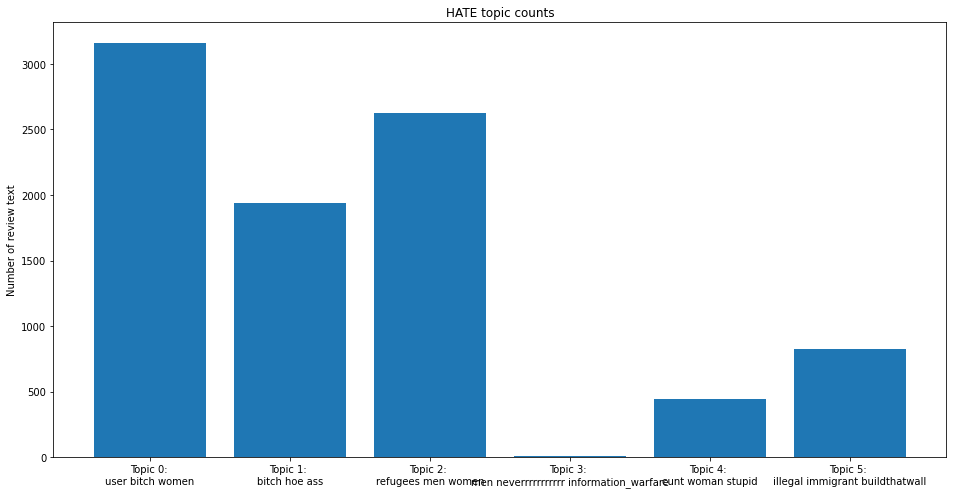

In [ ]:
top_3_words = get_top_n_words(3, lsa_keys, document_term_matrix, tfidf_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lsa_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lsa_categories, lsa_counts);
ax.set_xticks(lsa_categories);
ax.set_xticklabels(labels);
ax.set_ylabel('Number of review text');
ax.set_title('HATE topic counts');
plt.show();

In [ ]:
tsne_lsa_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lsa_vectors = tsne_lsa_model.fit_transform(lsa_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 9000 samples in 0.011s...
[t-SNE] Computed neighbors for 9000 samples in 0.593s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9000
[t-SNE] Computed conditional probabilities for sample 2000 / 9000
[t-SNE] Computed conditional probabilities for sample 3000 / 9000
[t-SNE] Computed conditional probabilities for sample 4000 / 9000
[t-SNE] Computed conditional probabilities for sample 5000 / 9000
[t-SNE] Computed conditional probabilities for sample 6000 / 9000
[t-SNE] Computed conditional probabilities for sample 7000 / 9000
[t-SNE] Computed conditional probabilities for sample 8000 / 9000
[t-SNE] Computed conditional probabilities for sample 9000 / 9000
[t-SNE] Mean sigma: 0.009992
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.889709
[t-SNE] KL divergence after 2000 iterations: 1.007432


In [ ]:
def get_mean_topic_vectors(keys, two_dim_vectors):
    '''
    returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(n_topics):
        reviews_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                reviews_in_that_topic.append(two_dim_vectors[i])    
        
        reviews_in_that_topic = np.vstack(reviews_in_that_topic)
        mean_review_in_that_topic = np.mean(reviews_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_review_in_that_topic)
    return mean_topic_vectors

In [ ]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:n_topics]

In [ ]:
top_3_words_lsa = get_top_n_words(3, lsa_keys, document_term_matrix, tfidf_vectorizer)
lsa_mean_topic_vectors = get_mean_topic_vectors(lsa_keys, tsne_lsa_vectors)

plot = figure(title="t-SNE Clustering of {} LSA Topics".format(n_topics), plot_width=700, plot_height=700)
plot.scatter(x=tsne_lsa_vectors[:,0], y=tsne_lsa_vectors[:,1], color=colormap[lsa_keys])

for t in range(n_topics):
    label = Label(x=lsa_mean_topic_vectors[t][0], y=lsa_mean_topic_vectors[t][1], 
                  text=top_3_words_lsa[t], text_color=colormap[t])
    plot.add_layout(label)
    
show(plot)

GlyphRenderer(id='1139', ...)

Here are the terms that differentiate the review text from a general English corpus.

Here are the terms in review text that are most associated with Tops department: